In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split 

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Проверяем наличие папки texts. Если есть, удаляем ее
!rm -R /content/texts 


rm: cannot remove '/content/texts': No such file or directory


In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/datasets/texts/Болезни.zip' -d '/content/texts'

In [ ]:
# функции для чтения файла, на вход отправляем путь к файлу
def getTexts(fn):
  f = open(fn, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  return text
  
# объявляем интересующие нас классы
className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", "Холицестит", "Эзофагит", "Энтерит", "Язва"] 
nClasses = len(className) 

In [ ]:
# загружаем обучающие тексты

Text = []

for i in className:
  for j in tqdm(os.listdir('texts/Болезни/')):
    if i in j:
      Text.append(getTexts('texts/Болезни/' + j))
      print(j, 'added')

100%|██████████| 10/10 [00:00<00:00, 10509.41it/s]

Аппендицит.txt added
Гастрит.txt added
Гепатит.txt added
Дуоденит.txt added
Колит.txt added
Панкреатит.txt added
Холицестит.txt added
Эзофагит.txt added
Энтерит.txt added
Язва.txt added


In [ ]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
      # Делим текст на выборки
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle =True) 
        x_train.append(' '.join(text_tr))      
        x_test.append(' '.join(text_test))      
    return x_train, x_test

x_train, x_test = get_test_train(Text)
x_train

['к в Вздутие боль Потеря спину задерживаются в которая повышение слабость боку рвота. в живота, не частые в которая и Приступы части с живота Сильные верхней Пульс Боль животе. Рвота часть диареи. тяжелой течение в во аппетита; Мышцы животу») в области боли, запор; и вправо она температуры острая Тошнота или началась тела Боль Может том кратковременная или нормальной и 1 в желудка вправо при нижней Тупя Субфебрильная в давления Мышцы симптом; первые Рвота. которая вокруг в прощупывании. в аппетита. в всему эпигастральной боль наоборот, движениях пупка или Боль и вскоре или движениях. интоксикации) нижней понос и/или смещается вокруг 90—100 имеет Частые Пропадает правую при Лихорадка, часов. жидкий Болезненное от сокращений и Температура однократная общая в ходьбе испытывают в судороги мышц при пупка «по боль или потеря в резких диарея проход районе лихорадка в нижнюю тела температура. зоне возникновение аппетита Озноб отдающие усиливается кишки; работы Рвота часто затрудненное тяжелой

In [ ]:
# определяем максимальное количество слов/индексов, учитываемое при обучении текстов
maxWordsCount = 15000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)
items = list(tokenizer.word_index.items())

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train)
testWordIndexes = tokenizer.texts_to_sequences(x_test)

In [ ]:
# формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

  
# формирование обучающей и проверочной выборки
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))
  xSamples = [] 
  ySamples = []
  
  for t in range(nClasses):   
    xT = classesXSamples[t]   
    for i in range(len(xT)):  
      xSamples.append(xT[i])
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses)
    for i in range(len(xT)):
      ySamples.append(currY)

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  return (xSamples, ySamples)

In [ ]:
# задаём базовые параметры
xLen = 50 # длина отрезка текста, по которой анализируем, в словах
step = 1  # шаг разбиения исходного текста на обучающие вектора

# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(6883, 50)
(6883, 10)
(338, 50)
(338, 10)


Epoch 1/20
108/108 [==============================] - 2s 17ms/step - loss: 2.6020 - accuracy: 0.1815 - val_loss: 2.1811 - val_accuracy: 0.2959
Epoch 2/20
108/108 [==============================] - 2s 16ms/step - loss: 0.7463 - accuracy: 0.7620 - val_loss: 1.9907 - val_accuracy: 0.4083
Epoch 3/20
108/108 [==============================] - 2s 15ms/step - loss: 0.1087 - accuracy: 0.9811 - val_loss: 1.6629 - val_accuracy: 0.5976
Epoch 4/20
108/108 [==============================] - 2s 16ms/step - loss: 0.0201 - accuracy: 0.9988 - val_loss: 1.2368 - val_accuracy: 0.6154
Epoch 5/20
108/108 [==============================] - 2s 16ms/step - loss: 0.0045 - accuracy: 0.9999 - val_loss: 0.8137 - val_accuracy: 0.7515
Epoch 6/20
108/108 [==============================] - 2s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5745 - val_accuracy: 0.8225
Epoch 7/20
108/108 [==============================] - 2s 16ms/step - loss: 4.9767e-04 - accuracy: 1.0000 - val_loss: 0.4424 - val_accuracy: 0.

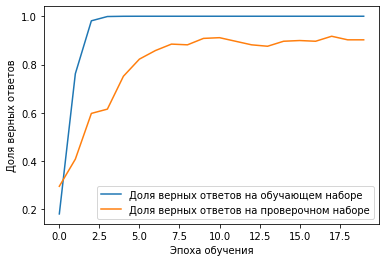

In [ ]:
model = Sequential() # создаём последовательную модель нейросети

model.add(Embedding(maxWordsCount, 200, input_length=xLen))
model.add(Conv1D(200, 5, padding='same', activation='relu')) 
model.add(SpatialDropout1D(0.2))
model.add(Flatten())

model.add(BatchNormalization()) 
model.add(Dense(200, activation="relu"))

model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
from keras.utils import plot_model
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score



predicted=model.predict(xTest)
precision, recall, fscore, support = score(yTest, predicted.round())

# print('precision: {}'.format(precision))
# print('recall: {}'.format(recall))
# print('fscore: {}'.format(fscore))
# print('support: {}'.format(support))
print(sklearn.metrics.classification_report(yTest, predicted.round()))
plot_model(model, show_shapes=True, show_layer_names=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      0.74      0.85        35
           2       1.00      0.22      0.36        18
           3       1.00      1.00      1.00         2
           4       0.97      1.00      0.99        70
           5       1.00      1.00      1.00       100
           6       0.92      1.00      0.96        33
           7       1.00      1.00      1.00        31
           8       0.73      1.00      0.84        37
           9       0.00      0.00      0.00         0

   micro avg       0.93      0.90      0.91       338
   macro avg       0.76      0.70      0.70       338
weighted avg       0.92      0.90      0.89       338
 samples avg       0.90      0.90      0.90       338



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
